In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)

In [41]:
# TODO: change this to yours ...
DATA_DIR = "Desktop/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join(DATA_DIR, "train.csv")
val_csv_file = os.path.join(DATA_DIR, "valid.csv")
test_csv_file = os.path.join(DATA_DIR, "test.csv")
ehr_pkl_file = os.path.join(DATA_DIR, "ehr_preprocessed_seq_by_day_cat_embedding.pkl")

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [43]:
#Option1 : Aggregate features by mean over the days



# Extract EHR features and IDs
ehr_features = ehr_data["feat_dict"]
ehr_ids = list(ehr_features.keys())

# Convert to DataFrame (each row is an admission)
ehr_df = pd.DataFrame({
    "id": ehr_ids,
    "ehr_matrix": [ehr_features[id] for id in ehr_ids]
})

# Merge with labels from train/val/test DataFrames
def merge_labels(df, ehr_df):
    return df[["id", "readmitted_within_30days"]].merge(ehr_df, on="id", how="inner")

train_ehr = merge_labels(train_df, ehr_df)
val_ehr = merge_labels(val_df, ehr_df)


def aggregate_ehr(df):
    # Aggregate features (example: mean over days)
    df["ehr_mean"] = df["ehr_matrix"].apply(lambda x: np.mean(x, axis=0))
    
    # Convert to numpy arrays
    X = np.stack(df["ehr_mean"].values)
    y = df["readmitted_within_30days"].astype(int).values
    
    return X, y

X_train, y_train = aggregate_ehr(train_ehr)
X_val, y_val = aggregate_ehr(val_ehr)


In [45]:
#Option 2 Aggregate features by last day
"""
X_train = []
for idx, row in train_df.iterrows():
    X_train.append(ehr_data["feat_dict"][row["id"]][-1])
X_train = np.array(X_train)
print(X_train.shape)
print('train_data:',X_train,'\n')

X_val = []
for idx, row in val_df.iterrows():
    X_val.append(ehr_data["feat_dict"][row["id"]][-1])
X_val = np.array(X_val)
print(X_val.shape)
print('validation_data:,',X_val,'\n')




y_train = train_df['readmitted_within_30days'].values
y_val = val_df['readmitted_within_30days'].values

"""

'\nX_train = []\nfor idx, row in train_df.iterrows():\n    X_train.append(ehr_data["feat_dict"][row["id"]][-1])\nX_train = np.array(X_train)\nprint(X_train.shape)\nprint(\'train_data:\',X_train,\'\n\')\n\nX_val = []\nfor idx, row in val_df.iterrows():\n    X_val.append(ehr_data["feat_dict"][row["id"]][-1])\nX_val = np.array(X_val)\nprint(X_val.shape)\nprint(\'validation_data:,\',X_val,\'\n\')\n\n\n\n\ny_train = train_df[\'readmitted_within_30days\'].values\ny_val = val_df[\'readmitted_within_30days\'].values\n\n'

In [47]:
from scipy.stats import pointbiserialr 
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]  

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []


# Calculate correlation for each feature
for i in range(X_train.shape[1]):
    if np.std(X_train[:, i]) == 0:  # Skip constant features
        correlations.append(0)
        p_values.append(1)
    else:
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)
        


# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',
    
    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',
    
    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.01,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.01,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]
        
        # Skip binary features for variance check
        check_variance = ftype not in ['icd']
        
        # Apply type-specific rules
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (np.abs(row['Correlation']) < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > thresholds['correlation']['max_pvalue']):
            features_to_remove.append(feature)
            


    
filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features) 
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features) 
                     if i not in remove_indices]





/var/folders/m_/yqb8yddn11149xyfft57yhsm0000gn/T/ipykernel_79947/2291655186.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [48]:
# print preprocessing result

print(f"\nRecommended features to remove (last) ({len(removal_df)} total):")
print(removal_df[['Feature', 'Zero_Ratio', 'Std_Dev', 'Correlation', 'P-value']])
print("Recommended removal features list:")
print(removal_df['Feature'].tolist())


Recommended features to remove (last) (39 total):
                   Feature  Zero_Ratio   Std_Dev  Correlation   P-value
54                 K65-K68    0.999950  0.015576    -0.008536  0.057676
24                 R40-R46    0.999950  0.102142    -0.003603  0.423045
8                  M80-M85    0.999909  0.007789    -0.004268  0.342633
29                 B25-B34    0.999877  0.029816     0.004573  0.309156
26                 N20-N23    0.999863  0.008993    -0.004928  0.273169
73                 N60-N65    0.999831  0.025824     0.006283  0.162356
47                 G89-G99    0.999813  0.182042     0.007699  0.086893
44                 M50-M54    0.999786  0.000000     0.000000  1.000000
111  Basophils Joint Fluid    0.999758  0.000000     0.000000  1.000000
57                 B65-B83    0.999735  0.006359    -0.003484  0.438443
80                 K40-K46    0.999667  0.000000     0.000000  1.000000
93                 R90-R94    0.999653  0.000000     0.000000  1.000000
39           

In [49]:
#Plot Confusion Matrix
from sklearn import metrics
def plot_confusion_matrix(train_Y,log_pre1):
    confusion_matrix = metrics.confusion_matrix(train_Y,log_pre1)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    
    cm_display.plot(cmap='Blues')
    plt.tight_layout()
    plt.show()


In [53]:
# Evaluate model performance metrics
from sklearn.metrics import recall_score, f1_score, accuracy_score, auc, precision_score, roc_curve
from sklearn import metrics

def metric_score(train_Y, log_pre1, train_scaler, model_name, dataset_name, pre_pro):
    print('{} model {} — Recall: {}'.format(model_name, dataset_name, recall_score(train_Y, log_pre1)))
    print('{} model {} — Precision: {}'.format(model_name, dataset_name, precision_score(train_Y, log_pre1)))
    print('{} model {} — Accuracy: {}'.format(model_name, dataset_name, accuracy_score(train_Y, log_pre1)))
    print('{} model {} — F1 score: {}'.format(model_name, dataset_name, f1_score(train_Y, log_pre1)))
    confusion_matrix = metrics.confusion_matrix(train_Y, log_pre1)
    specificity = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])
    print('{} model {} — Specificity: {}'.format(model_name, dataset_name, specificity))
    TN, FP, FN, TP = confusion_matrix.ravel()
    print('{} model {} — Positive Predictive Value (PPV): {}'.format(model_name, dataset_name, TP / (TP + FP)))
    print('{} model {} — Negative Predictive Value (NPV): {}'.format(model_name, dataset_name, TN / (TN + FN)))
    fpr, tpr, thresholds = roc_curve(train_Y, pre_pro)
    print('{} model {} — Area Under Curve (AUC): {}'.format(model_name, dataset_name, auc(fpr, tpr)))


In [55]:
def plot_roc(model,y_scores,y_true,model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_point = (fpr[optimal_idx], tpr[optimal_idx])
    
    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line color changed to red
    plt.scatter(optimal_point[0], optimal_point[1], marker='o', color='red')
    plt.text(optimal_point[0] + 0.03, optimal_point[1] - 0.05, f'{optimal_threshold:.3f} ({optimal_point[0]:.3f},{optimal_point[1]:.3f})', fontsize=12, verticalalignment='center', color='blue')
    plt.plot([optimal_point[0], optimal_point[0]], [optimal_point[1], optimal_point[1]], 'k--', color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC CURVE')
    plt.text(0.7, 0.4, f'AUC = {roc_auc:.3f}', ha='right', color='blue')
    plt.show()

In [57]:
from xgboost import XGBClassifier

# Initialize and train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:41:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


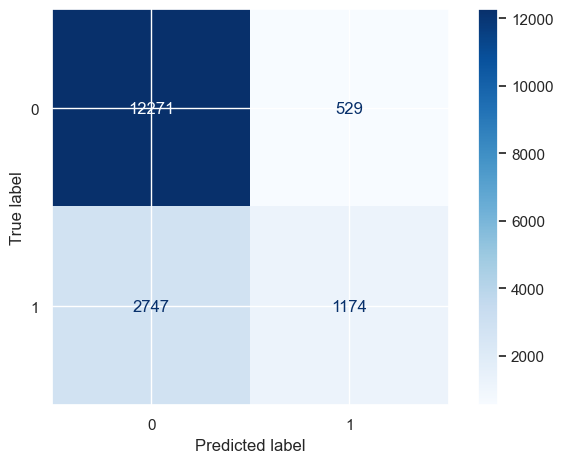

In [59]:
plot_confusion_matrix(y_val,y_pred)

In [61]:
metric_score(y_val, y_pred, X_val, 'xgboost', 'before feature selection', y_prob)


xgboost model before feature selection — Recall: 0.29941341494516704
xgboost model before feature selection — Precision: 0.6893716970052848
xgboost model before feature selection — Accuracy: 0.8040787034268285
xgboost model before feature selection — F1 score: 0.4174964438122333
xgboost model before feature selection — Specificity: 0.958671875
xgboost model before feature selection — Positive Predictive Value (PPV): 0.6893716970052848
xgboost model before feature selection — Negative Predictive Value (NPV): 0.8170861632707418
xgboost model before feature selection — Area Under Curve (AUC): 0.6978621525121143


/var/folders/m_/yqb8yddn11149xyfft57yhsm0000gn/T/ipykernel_79947/3790403714.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([optimal_point[0], optimal_point[0]], [optimal_point[1], optimal_point[1]], 'k--', color='red')


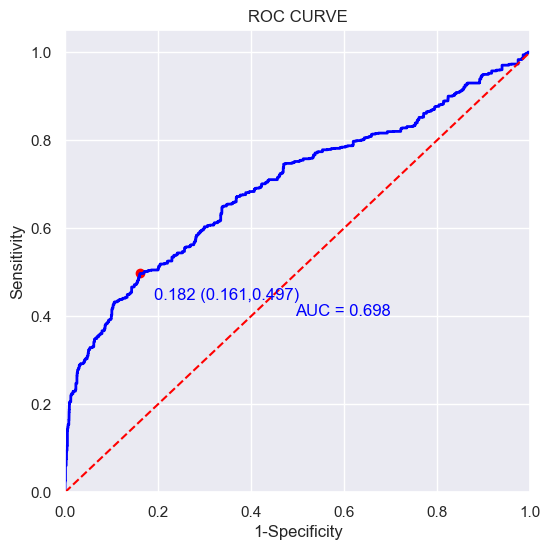

In [63]:
plot_roc(model, y_prob, y_val, 'XGBoost before feature selection')


In [65]:
# Initialize and train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_filtered, y_train)

# Predict on validation set
y_pred = model.predict(X_val_filtered)
y_prob = model.predict_proba(X_val_filtered)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:41:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


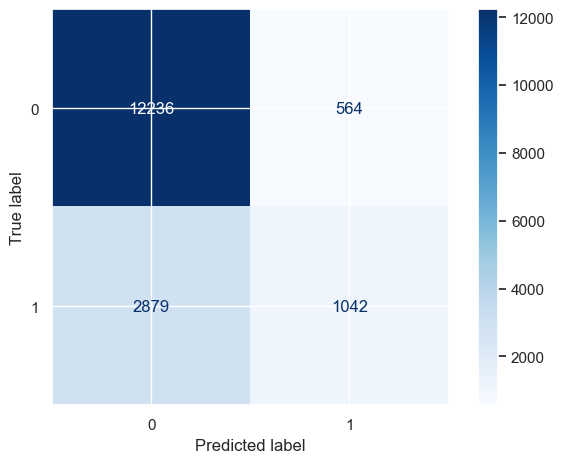

In [67]:
plot_confusion_matrix(y_val,y_pred)

In [71]:
metric_score(y_val, y_pred, X_val, 'xgboost', 'after feature selection', y_prob)



xgboost model after feature selection — Recall: 0.26574853353736294
xgboost model after feature selection — Precision: 0.6488169364881694
xgboost model after feature selection — Accuracy: 0.7940912624843012
xgboost model after feature selection — F1 score: 0.37705807852361134
xgboost model after feature selection — Specificity: 0.9559375
xgboost model after feature selection — Positive Predictive Value (PPV): 0.6488169364881694
xgboost model after feature selection — Negative Predictive Value (NPV): 0.8095269599735362
xgboost model after feature selection — Area Under Curve (AUC): 0.6898513612598827


/var/folders/m_/yqb8yddn11149xyfft57yhsm0000gn/T/ipykernel_79947/3790403714.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([optimal_point[0], optimal_point[0]], [optimal_point[1], optimal_point[1]], 'k--', color='red')


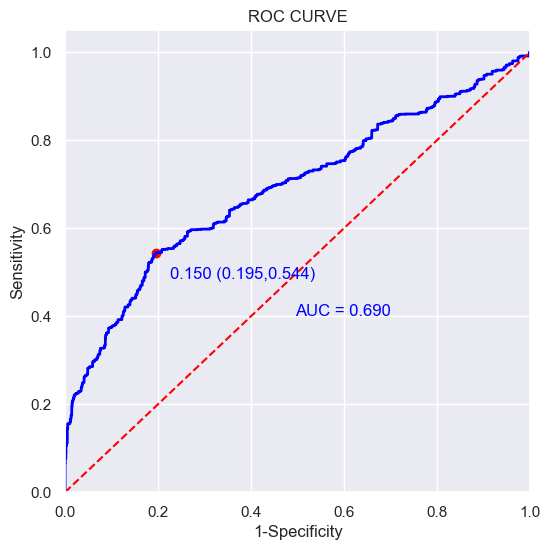

In [73]:
plot_roc(model,y_prob,y_val,'XGBoost after feature selection')


In [75]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]


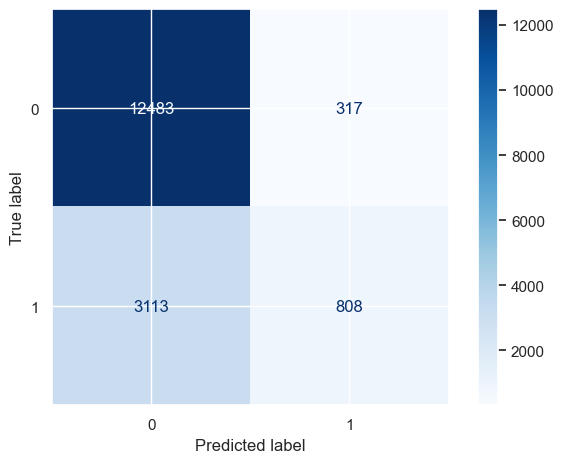

In [77]:
plot_confusion_matrix(y_val,y_pred)

In [81]:
metric_score(y_val,y_pred,X_val,'GradientBoosting','before feature selection',y_prob)

GradientBoosting model before feature selection — Recall: 0.20606988013261923
GradientBoosting model before feature selection — Precision: 0.7182222222222222
GradientBoosting model before feature selection — Accuracy: 0.7948687279468931
GradientBoosting model before feature selection — F1 score: 0.3202536662703131
GradientBoosting model before feature selection — Specificity: 0.975234375
GradientBoosting model before feature selection — Positive Predictive Value (PPV): 0.7182222222222222
GradientBoosting model before feature selection — Negative Predictive Value (NPV): 0.8003975378302128
GradientBoosting model before feature selection — Area Under Curve (AUC): 0.7404785828710788


/var/folders/m_/yqb8yddn11149xyfft57yhsm0000gn/T/ipykernel_79947/3790403714.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([optimal_point[0], optimal_point[0]], [optimal_point[1], optimal_point[1]], 'k--', color='red')


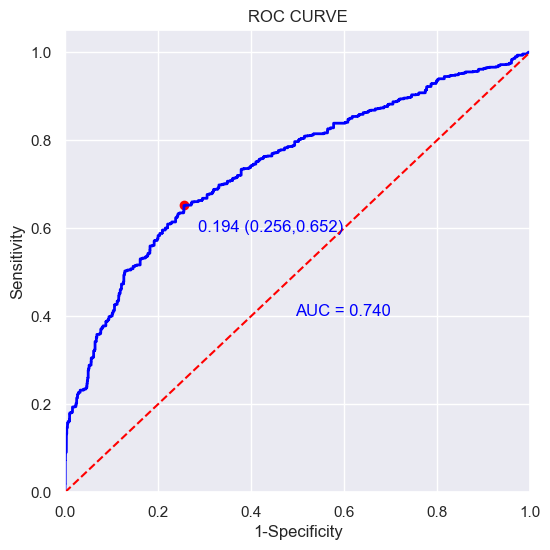

In [83]:
plot_roc(model,y_prob,y_val,'GradientBoosting before feature selection')

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_filtered, y_train)

# Predict on validation set
y_pred = model.predict(X_val_filtered)
y_prob = model.predict_proba(X_val_filtered)[:, 1]


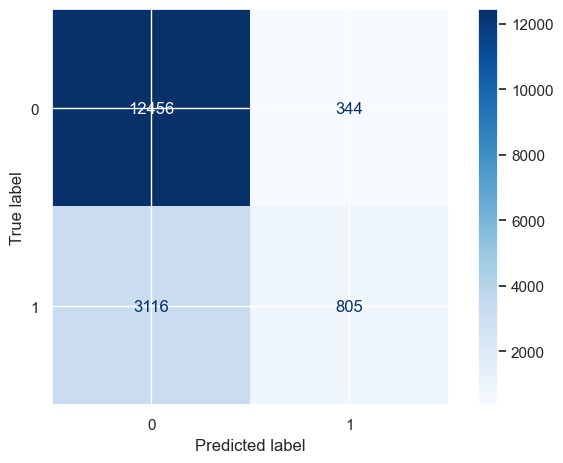

In [86]:
plot_confusion_matrix(y_val,y_pred)

In [91]:
metric_score(y_val,y_pred,X_val,'GradientBoosting','after feature selection',y_prob)

GradientBoosting model after feature selection — Recall: 0.20530476919153276
GradientBoosting model after feature selection — Precision: 0.700609225413403
GradientBoosting model after feature selection — Accuracy: 0.7930745768793732
GradientBoosting model after feature selection — F1 score: 0.3175542406311637
GradientBoosting model after feature selection — Specificity: 0.973125
GradientBoosting model after feature selection — Positive Predictive Value (PPV): 0.700609225413403
GradientBoosting model after feature selection — Negative Predictive Value (NPV): 0.79989725147701
GradientBoosting model after feature selection — Area Under Curve (AUC): 0.7398396355362152


/var/folders/m_/yqb8yddn11149xyfft57yhsm0000gn/T/ipykernel_79947/3790403714.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([optimal_point[0], optimal_point[0]], [optimal_point[1], optimal_point[1]], 'k--', color='red')


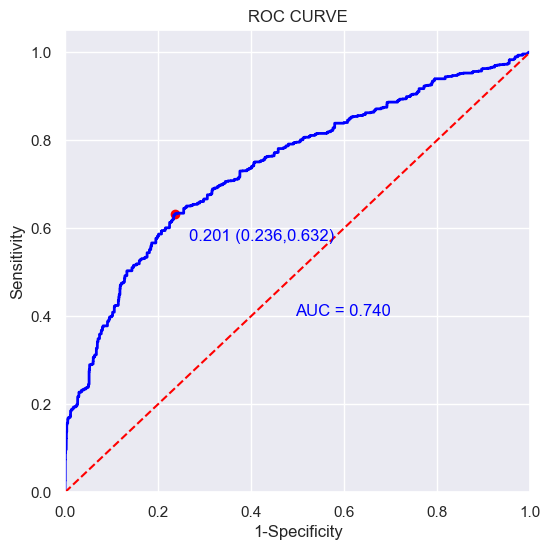

In [93]:
plot_roc(model,y_prob,y_val,'GradientBoosting after feature selection')